In [1]:
# %%

import sys
from pathlib import Path
import os
sys.path.append(str(Path.cwd().parent))
from pprint import pprint

# %%
# %%
# %%
import pyrootutils
# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)
from pprint import pprint

from pathlib import Path
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import sys
from pathlib import Path

import torch.nn as nn
import hydra

import torch
import seaborn as sns
from omegaconf import OmegaConf
from pytorch_lightning import LightningModule

import src.utils.default as utils
sitk.ProcessObject_SetGlobalWarningDisplay(False)
from src.data.bvisa_dm import CS_Dataset

import matplotlib.pyplot as plt

from monai.metrics import compute_dice, compute_hausdorff_distance, compute_iou

import os
from src.data.splits import (bvisa_splits, bvisa_left_sulci_labels,
                             bvisa_right_sulci_labels, bvisa_padding_dims,
                             bad_via11, via11_qc)
from src.utils.general import crop_image_to_content, resample_volume
from src.utils.general import sitk_cropp_padd_img_to_size


# Compare the segmentation results of the different methods quantitatively with metrics DSC and HD

In [2]:
# from src.data.splits import (bvisa_splits, bvisa_left_sulci_labels,
#                              bvisa_right_sulci_labels, bvisa_padding_dims,
#                              bad_via11, via11_qc)
# from src.utils.general import crop_image_to_content, resample_volume
# from src.utils.general import sitk_cropp_padd_img_to_size


# class CS_eval_via(CS_Dataset):
#     def __init__(self,
#                  corrections_path: str,
#                  resample: list[float] | None = None,
#                  crop2content: bool = False,
#                  croppadd2same_size: str = None):
#         """Constructor for CS_Dataset class

#         Args:
#             corrections_path (str): Path to corrected segmentations.
#             resample (list[x, y, z] | None, optional): Resample the images to a given resolution.
#             crop2content (bool, optional): Crop the images to the content of the image.
#             padd2same_size (string, optional): Pad-cropps the images to the same size depending on image type.
#         """

#         # save dataset hyperparameters
#         self.corrections_path = Path(corrections_path)
#         self.resample = list(resample) if resample is not None else None
#         self.crop2content = crop2content
#         self.croppadd2same_size = croppadd2same_size
#         if self.croppadd2same_size:
#             self.cropPadd_size = [int(x) for x in croppadd2same_size.split('-')]
#         # load corresponding image and target paths
#         self.img_paths = []
#         self.target_paths = []
#         self.corrected_target_paths = []
#         self.caseids = []

#         self._load_via11_corrected()

#     def _load_via11_corrected(self):
#         """Load VIA11 dataset"""
#         drcmr_path = Path(os.environ.get('VIA11_DRCMR'))
#         cfin_path = Path(os.environ.get('VIA11_CFIN'))

#         cfin_subjs = [subj for subj in cfin_path.iterdir() if subj.is_dir()]
#         drcmr_subjs = [subj for subj in drcmr_path.iterdir() if subj.is_dir()]
#         all_subjs = cfin_subjs + drcmr_subjs
        
#         # filter only corrected subjects

#         cfin_corr = set([str(x.name).removeprefix('LSulci_').removeprefix('RSulci_')[:10] for x in (corrected_path/'CFIN').glob('*.nii.gz')])
#         drcmr_corr = set([str(x.name).removeprefix('LSulci_').removeprefix('RSulci_')[:10] for x in (corrected_path/'DRCMR').glob('*.nii.gz')])
#         all_corr = cfin_corr.union(drcmr_corr)
#         all_subjs = [subj for subj in all_subjs if subj.name in all_corr]
        
#         for subj in all_subjs:
#             self.__load_subject_via11(subj)


#     def __load_subject_via11(self, subj):
#         sulci_path = os.environ.get('SEGM_PATH')

#         # get image input paths
#         image_paths = []

#         image_paths.append(subj/f't1mri/default_acquisition/default_analysis/segmentation/skull_stripped_{subj.name}.nii.gz')

#         subj_id = subj.name
#         self.caseids.append(subj_id)
#         self.img_paths.append(image_paths)

#         # get target paths
#         target_paths = []
#         target_paths.append(subj/f'{sulci_path}/LSulci_{subj_id}_default_session_best.nii.gz')
#         target_paths.append(subj/f'{sulci_path}/RSulci_{subj_id}_default_session_best.nii.gz')
#         self.target_paths.append(target_paths)
        
#         # get corrected  target paths
#         corr_paths = []
        
#         pref = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited'
#         center = str(target_paths[0]).split('BrainVisa/BrainVisa/')[1].split('/')[0]
#         subj = str(target_paths[0]).split(center)[1][1:11]
#         corrp_L = f'{pref}/{center}/LSulci_{subj}_default_session_best_edit_NHT.nii.gz'
#         corrp_R = f'{pref}/{center}/RSulci_{subj}_default_session_best_edit_NHT.nii.gz'
    
#         corr_paths.append(corrp_L)
#         corr_paths.append(corrp_R)
#         self.corrected_target_paths.append(corr_paths)
        

#     def _load_image_target(self, idx):
#         # load image
#         image = sitk.ReadImage(str(self.img_paths[idx][0]))
#         # reorient to RAS to have similar orientation as BVISA images
#         image = sitk.DICOMOrient(image, 'RAS')
        
#         # load target
#         ltarget = sitk.ReadImage(str(self.target_paths[idx][0]))
#         rtarget = sitk.ReadImage(str(self.target_paths[idx][1]))
#         target = sitk.Cast((ltarget + rtarget) > 0, sitk.sitkInt16)
#         # reorient to RAS to have similar orientation as BVISA images
#         target = sitk.DICOMOrient(target, 'RAS')

#         # load target
#         ltarget = sitk.ReadImage(str(self.corrected_target_paths[idx][0]))
#         rtarget = sitk.ReadImage(str(self.corrected_target_paths[idx][1]))
#         corr_target = sitk.Cast((ltarget + rtarget) > 0, sitk.sitkInt16)
#         # reorient to RAS to have similar orientation as BVISA images
#         corr_target = sitk.DICOMOrient(corr_target, 'RAS')
        
#         return image, target, corr_target

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
    
#         image, target, corr_target = self._load_image_target(idx)

#         # pre-process images
#         image, target, corr_target = self._preprocess(image, target, corr_target)

#         # post-process images
#         image, target, corr_target = self._postprocess(image, target, corr_target)

#         sample = {'image': image, 'target': target, 'corr_target': corr_target}

#         # get caseid
#         sample['caseid'] = self.caseids[idx]

#         return sample

#     def _preprocess(self, image, target, corr_target):
#         """Converts from sitk.Image to torch.Tensor and
#            ensures that targets have proper labels and
#            images are normalized.

#         Args:
#             image (sitk.Image): Input image.
#             target (sitk.Image): Target image.

#         Returns:
#             tuple(Tensor, Tensor): Pre-processed image and target.
#         """
#         # resample if needed
#         if self.resample is not None:
#             image_interpolator = sitk.sitkLinear
#             image = resample_volume(image, self.resample, image_interpolator)
#             target = resample_volume(target, self.resample,
#                                      interpolator=sitk.sitkNearestNeighbor)
#             corr_target = resample_volume(corr_target, self.resample,
#                                      interpolator=sitk.sitkNearestNeighbor)
        
#         # crop to content
#         if self.crop2content:
#             img2crop = sitk.GetArrayFromImage(image)
#             target2crop = sitk.GetArrayFromImage(target)
#             coorrtarget2crop = sitk.GetArrayFromImage(corr_target)
#             image, min_coords, max_coords = crop_image_to_content(img2crop)
#             target, _, __ = crop_image_to_content(target2crop, min_coords, max_coords)
#             corr_target, _, __ = crop_image_to_content(coorrtarget2crop, min_coords, max_coords)
#             image = sitk.GetImageFromArray(image)
#             target = sitk.GetImageFromArray(target)
#             corr_target = sitk.GetImageFromArray(corr_target)

#         if self.croppadd2same_size:
#             # cropp-padding if needed
#             image = sitk_cropp_padd_img_to_size(image, self.cropPadd_size)
#             target = sitk_cropp_padd_img_to_size(target, self.cropPadd_size)
#             corr_target = sitk_cropp_padd_img_to_size(corr_target, self.cropPadd_size)

#         # convert to numpy
#         image = sitk.GetArrayFromImage(image)
#         target = sitk.GetArrayFromImage(target)
#         corr_target = sitk.GetArrayFromImage(corr_target)


#         # min-max normalization of the image
#         image = (image - image.min()) / (image.max() - image.min())

#         return torch.Tensor(image), torch.tensor(target, dtype=torch.long), torch.tensor(corr_target, dtype=torch.long)

#     def _postprocess(self, image: torch.Tensor, target: torch.Tensor, corr_target):
#         # padd if needed
#         # TODO: FIX THE ERROR WITH THE ACTIVE PADDING
#         # if self.padd2same_size:
#         #     raise ValueError('Should not be used anymore')
#         #     size_key = 'original' if self.resample is None else str(self.resample)
#         #     pad_dims = bvisa_padding_dims[self.input][size_key]
#         #     padd = SpatialPad(pad_dims, mode='constant', value=0)
#         #     image = padd(torch.unsqueeze(image, dim=0))[0]
#         #     target = padd(torch.unsqueeze(target, dim=0))[0]

#         # add channel dimension to the image
#         image = torch.unsqueeze(image, 0)
#         return image, target, corr_target

In [3]:

# # %%
# CHKP = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/logs_finetuning/CS1x_via11SegmSST_monaiUnet-fullFinetune/runs/2023-05-24_11-16-51/checkpoints/epoch-253-Esubj-0.4463.ckpt')
# print(CHKP)
# out_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/skull_stripped_images')

# corrected_path = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited'
# corrected_path = Path(corrected_path)
# exp_name = CHKP.parent.parent.parent.parent.name
# out_path = out_path / exp_name
# out_path.mkdir(exist_ok=True, parents=True)
# cgf_path = CHKP.parent.parent / '.hydra' / 'config.yaml'
# finetune_cfg = OmegaConf.load(cgf_path)

# segm_model: LightningModule = hydra.utils.instantiate(finetune_cfg.model)
# # sst_ds = hydra.utils.instantiate(finetune_cfg.data)
# # print(finetune_cfg.data)
# segm_model = segm_model.load_from_checkpoint(CHKP).to('cuda')
# segm_model = segm_model.eval()


# # %% [markdown]
# # # Load via validation images

# # %% USE ONLY FOR 1X DATASET
# finetune_cfg.data.dataset_cfg.resample = [1.1, 1.1, 1.5]


# # %%
# croppadd2same_size =  finetune_cfg.data.dataset_cfg.get('padd2same_size') if finetune_cfg.data.dataset_cfg.get('padd2same_size') else finetune_cfg.data.dataset_cfg.get('croppadd2same_size')

# # %%
# # via11DS = CS_Dataset('via11', 'mp2rage_skull_stripped',
# #                     'bvisa_CS', dataset_path='',
# #                      split='only_good',
# #                      crop2content=True,
# #                      preload=False,
# #                      resample=finetune_cfg.data.dataset_cfg.resample,
# #                      croppadd2same_size=croppadd2same_size)

# via11DS = CS_eval_via(corrected_path,
#                       resample=finetune_cfg.data.dataset_cfg.resample,
#                       croppadd2same_size=croppadd2same_size,
#                       crop2content=True,)

# # # %%
# # experiment_results = []
# # for idx in tqdm(range(len(via11DS))):
# #     sample = via11DS[idx]
# #     target_1hot = torch.nn.functional.one_hot(sample['target'].unsqueeze(0), num_classes=2).permute(0, 4, 1, 2, 3)
# #     corrected_target_1hot = torch.nn.functional.one_hot(sample['corr_target'].unsqueeze(0), num_classes=2).permute(0, 4, 1, 2, 3)
# #     with torch.no_grad():
# #         out = segm_model.forward(sample['image'].unsqueeze(0).to('cuda'))
# #     out_bin = torch.argmax(torch.softmax(out, dim=1), dim=1).cpu()
# #     out_1hot = torch.nn.functional.one_hot(out_bin, num_classes=2).permute(0, 4, 1, 2, 3)

# #     pred_dice = compute_dice(out_1hot, corrected_target_1hot, include_background=False)
# #     pred_iou = compute_iou(out_1hot, corrected_target_1hot, include_background=False)
# #     pred_hausdorff_distance = compute_hausdorff_distance(out_1hot, corrected_target_1hot,
# #                                                     include_background=False)

# #     bvisa_dice = compute_dice(target_1hot, corrected_target_1hot, include_background=False)
# #     bvisa_iou = compute_iou(target_1hot, corrected_target_1hot, include_background=False)
# #     bvisa_hausdorff_distance = compute_hausdorff_distance(target_1hot, corrected_target_1hot,
# #                                                     include_background=False)
    
# #     res = {'caseid': via11DS.caseids[idx],
# #             'bvisa_dice':bvisa_dice.item(),
# #             'bvisa_iou':bvisa_iou.item(),
# #             'bvisa_hausdorff_distance':bvisa_hausdorff_distance.item(),
# #             'bvisa_dice':bvisa_dice.item(),
# #             'bvisa_iou':bvisa_iou.item(),
# #             'bvisa_hausdorff_distance':bvisa_hausdorff_distance.item(),
# #            }
# #     experiment_results.append(res)
# # experiment_results = pd.DataFrame(experiment_results)
# # experiment_results = experiment_results.set_index('caseid')
# # experiment_results.loc['MEAN'] = experiment_results.mean()
# # experiment_results.loc['STD'] = experiment_results.std()
# # experiment_results.to_csv(f'{out_path}/via11_metrics.csv')

# # pprint(experiment_results)

In [4]:
# sitk.WriteImage(sitk.GetImageFromArray(s['image'].numpy()[0]), '/mrhome/vladyslavz/Pictures/tmp/img.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(s['target'].numpy().astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/target.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(post_prcosess_segm(s['target'].numpy()).astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/target_post.nii.gz')
# sitk.WriteImage(sitk.GetImageFromArray(s['corr_target'].numpy().astype(np.int16)), '/mrhome/vladyslavz/Pictures/tmp/corr_target.nii.gz')

In [10]:
df = '/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/skull_stripped_images/CS1x_via11SegmSST_monaiUnet-fullFinetune'

df = pd.read_csv(df+'/corr_via11_metrics.csv', index_col=0)
df = df.rename(columns={'bvisa_dice':'BrainVISA\nDSC', 'pred_dice':'Our U-Net\nwith VIA11 SST\nDSC',
                   'bvisa_hausdorff_distance':'BrainVISA\nHD', 'pred_hausdorff_distance':'Our U-Net\nwith VIA11 SST\nHD'})
df = df.loc[df.index.values[:-2]]
df = df[~df.index.isin(['sub-via305', 'sub-via311'])]

In [37]:
sns.set_palette("Set2", desat=0.8)
plt.rcParams['font.size']  = 25
sns.set_context("notebook", font_scale=1.5)


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


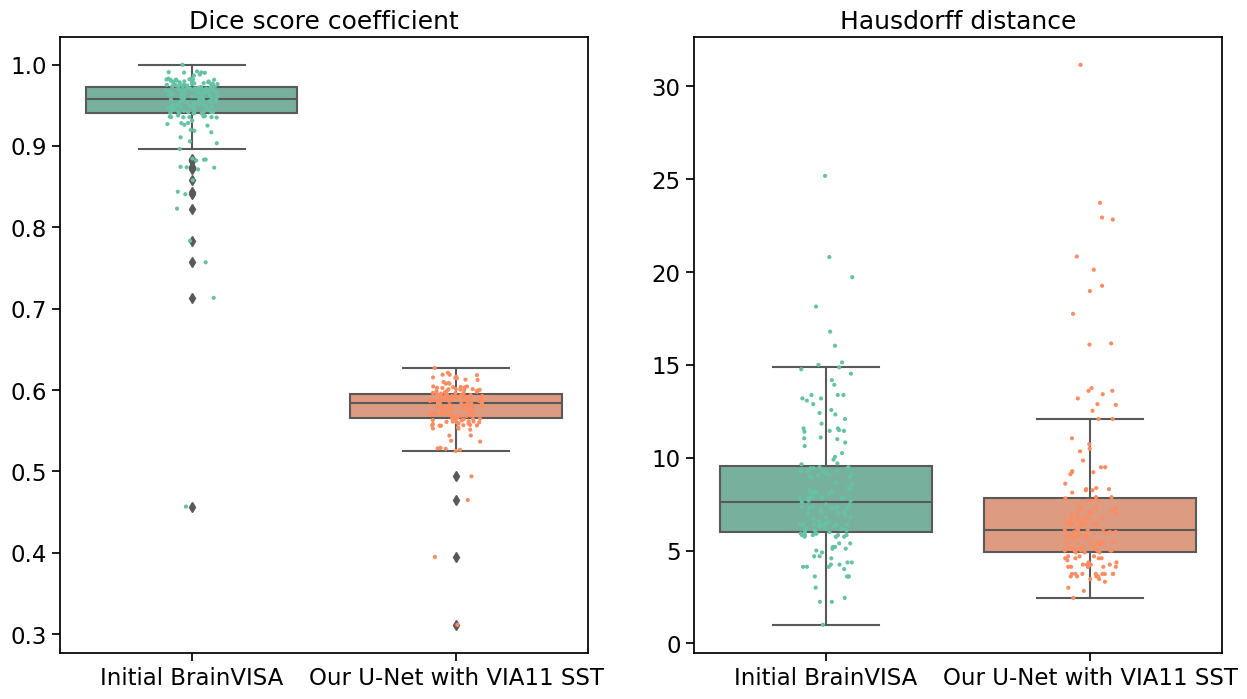

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.boxplot(data=df[['BrainVISA\nDSC', 'Our U-Net\nwith VIA11 SST\nDSC']], orient='v', showfliers = True, ax=ax[0])
sns.stripplot(data=df[['BrainVISA\nDSC', 'Our U-Net\nwith VIA11 SST\nDSC']],
              size=3, ax=ax[0],dodge=True, palette='Set2'
              )
ax[0].set_xticks([0, 1], ['Initial BrainVISA', 'Our U-Net with VIA11 SST'])

sns.boxplot(data=df[['BrainVISA\nHD', 'Our U-Net\nwith VIA11 SST\nHD']], orient='v', showfliers = False, ax=ax[1])
sns.stripplot(data=df[['BrainVISA\nHD', 'Our U-Net\nwith VIA11 SST\nHD']],
              size=3, ax=ax[1],dodge=True, palette='Set2'
              )
ax[1].set_xticks([0, 1], ['Initial BrainVISA', 'Our U-Net with VIA11 SST'])

ax[0].set_title('Dice score coefficient')
ax[1].set_title('Hausdorff distance')
# plt.legend()
# apply log scale
# plt.yscale('log')
plt.show()

In [50]:
import scipy.stats as stats

# Two arrays of dice scores
array_A = df['BrainVISA\nHD'].values
array_B = df['Our U-Net\nwith VIA11 SST\nHD'].values

# Perform a two-sample t-test assuming equal variances
t_statistic, p_value = stats.ttest_ind(array_A, array_B, equal_var=False)

# Print the t-statistic and p-value
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 2.0841592699606495
p-value: 0.03795958881553811


check statistical significance of lowe HD

In [51]:
df.mean()

BrainVISA\nDSC                    0.944704
bvisa_iou                         0.899585
BrainVISA\nHD                     8.315069
Our U-Net\nwith VIA11 SST\nDSC    0.577270
pred_iou                          0.406501
Our U-Net\nwith VIA11 SST\nHD     7.370345
dtype: float64

In [11]:
df[df['SST-MT HD'] <= df['BrainVISA HD']]

,BrainVISA DSC,bvisa_iou,BrainVISA HD,SST-MT DSC,pred_iou,SST-MT HD
caseid,,,,,,
sub-via015,0.942288,0.890874,8.306624,0.579511,0.407966,5.830952
sub-via018,0.960474,0.923954,7.810250,0.587902,0.416332,7.141428
sub-via050,0.873230,0.774986,16.031220,0.556681,0.385695,13.747727
sub-via059,0.952381,0.909091,8.306624,0.593647,0.422118,5.000000
sub-via086,0.874221,0.776547,8.185353,0.560261,0.389140,6.782330
...,...,...,...,...,...,...
sub-via462,0.884390,0.792741,12.884099,0.597135,0.425654,4.123106
sub-via495,0.903306,0.823662,11.445523,0.600203,0.428779,4.242641
sub-via508,0.857888,0.751142,12.409674,0.594722,0.423206,7.071068


# Compare Volumes and SRF Areas

In [33]:
import trimesh

In [75]:
demo_via = pd.read_excel('/mnt/projects/VIA_Vlad/nobackup/VIA11_fmriflanker_info_database_2021jan25.xlsx')
demo_via['caseid'] = [f'sub-via{x:03d}' for x in demo_via['via_id'].values]
caseid_hand = {r['caseid']:r['group'] for i,r in demo_via.iterrows() if ~np.isnan(r['handedness'])}

In [34]:
mesh_paths = [x for x in Path('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited').glob('**/*.ply')]
subj_meshes = []

for p in tqdm(mesh_paths):
     p = str(p)
     subj_id = p[p.find('sub-via'):p.find('sub-via')+10]
     side = 'L' if 'LSulci' in p else 'R'
     mesh = trimesh.load(p)
     volume = mesh.volume
     srfarea = mesh.area
     subj_meshes.append({'side':side, 'volume':volume, 'srfarea':srfarea, 'subj_id':subj_id})

100%|██████████| 331/331 [00:13<00:00, 25.45it/s]


In [82]:
subj_meshes = pd.DataFrame(subj_meshes)
assym_ratio = pd.DataFrame(subj_meshes.groupby('subj_id').apply(lambda x: (x[x['side']=='L']['volume'].values[0] / x[x['side']=='R']['volume'].values[0],
                                                                           x[x['side']=='L']['srfarea'].values[0] / x[x['side']=='R']['srfarea'].values[0])))
assym_ratio['Volume Asymmetry L/R'] = assym_ratio[0].apply(lambda x: x[0])
assym_ratio['Surface Area Assymetry L/R'] = assym_ratio[0].apply(lambda x: x[1])
assym_ratio['handedness'] = [caseid_hand[x] for x in assym_ratio.index.values]
assym_ratio.drop(0, axis=1, inplace=True)
# assym_ratio.loc[assym_ratio.handedness == 1,'handedness'] = 'Left Handed'
# assym_ratio.loc[assym_ratio.handedness == 2,'handedness'] = 'Ambidextrous'
# assym_ratio.loc[assym_ratio.handedness == 3,'handedness'] = 'Right Handed'

assym_ratio

,Volume Asymmetry L/R,Surface Area Assymetry L/R,handedness
subj_id,,,
sub-via003,1.014424,1.015841,3.0
sub-via004,1.097988,1.094163,3.0
sub-via005,0.949685,0.919406,3.0
sub-via010,1.097767,1.050237,2.0
sub-via013,1.018224,0.951722,3.0
...,...,...,...
sub-via511,0.877618,0.888657,3.0
sub-via512,0.976647,1.014557,3.0
sub-via518,1.050668,1.042143,3.0


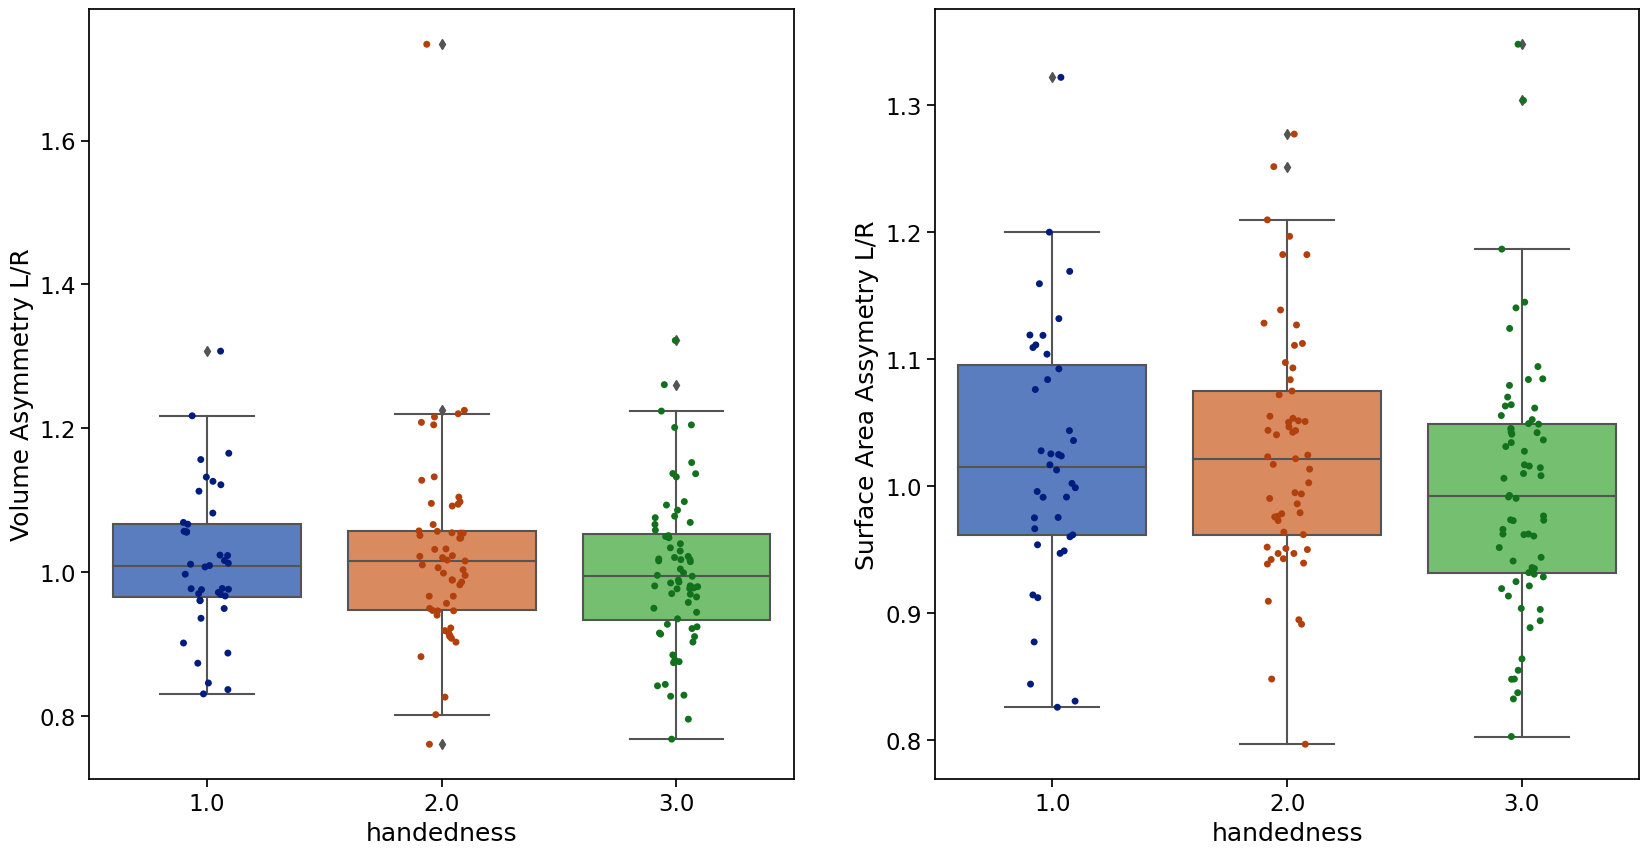

In [83]:
# plot assymetry ratio by handedness
sns.set_palette("muted")
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.boxplot(data=assym_ratio, x='handedness', y='Volume Asymmetry L/R', ax=ax[0])
sns.stripplot(data=assym_ratio, x='handedness', y='Volume Asymmetry L/R', ax=ax[0], dodge=True, palette='dark')

sns.boxplot(data=assym_ratio, x='handedness', y='Surface Area Assymetry L/R', ax=ax[1])
sns.stripplot(data=assym_ratio, x='handedness', y='Surface Area Assymetry L/R', ax=ax[1], dodge=True, palette='dark')
plt.show()

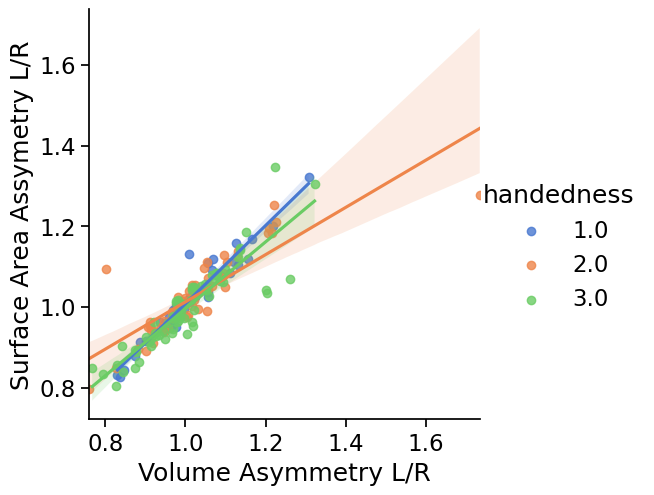

In [85]:
sns.lmplot(data=assym_ratio, x='Volume Asymmetry L/R', y='Surface Area Assymetry L/R', hue='handedness')

In [28]:
segmh_paths = [x for x in Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/segmentations').glob('sub*.nii.gz')]
save_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/segmentations')
from skimage.morphology import label, binary_dilation
from collections import Counter
def split_sulci(segm: np.ndarray):
    dil = segm[:, :, :]
    
    while len(np.unique((label(dil)))) > 3:
        dil = binary_dilation(dil)
    
    return label(dil)

In [29]:
res = [ ]
coords = []
for s in tqdm(segmh_paths):
    simg = sitk.GetArrayFromImage(sitk.ReadImage(str(s)))
    simg = split_sulci(simg)
    simg_lab = label(simg, connectivity=2)
    
    lab1_loc = np.stack(np.where(simg==1), 1).mean(0)[2]
    lab2_loc = np.stack(np.where(simg==2), 1).mean(0)[2]
    
    leftest_lab = 1 if lab1_loc < lab2_loc else 2
    rightest_lab = 2 if lab1_loc < lab2_loc else 1
    
    Lsulc = sitk.GetImageFromArray((simg*((simg_lab == leftest_lab))).astype(np.int16))
    Rsulc = sitk.GetImageFromArray((simg*((simg_lab == rightest_lab))).astype(np.int16))
    
    sitk.WriteImage(Lsulc, str(save_path / f'Lsulc{s.name}'))
    sitk.WriteImage(Rsulc, str(save_path / f'Rsulc{s.name}'))
    
    coords.append([np.stack(np.where(simg==1), 1).mean(0),
                   np.stack(np.where(simg==2), 1).mean(0)])
    res.append(np.unique(simg_lab, return_counts=True))

100%|██████████| 165/165 [01:20<00:00,  2.05it/s]


In [59]:
import trimesh
from sklearn.metrics import   mean_squared_error, r2_score

In [53]:
orig_rpath = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CENTRE/SUBJECT/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/RSulci_SUBJECT_default_session_best.ply'
orig_lpath = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CENTRE/SUBJECT/t1mri/default_acquisition/default_analysis/folds/3.1/default_session_best/segmentation/LSulci_SUBJECT_default_session_best.ply'

In [54]:
predicted_path = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/meshes')

In [94]:
mesh_paths = [x for x in Path('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited').glob('**/*.ply')]
subj_meshes = []

for p in tqdm(mesh_paths):
     
     # load corrected
     p = str(p)
     subj_id = p[p.find('sub-via'):p.find('sub-via')+10]
     side = 'L' if 'LSulci' in p else 'R'
     site = 'DRCMR' if 'DRCMR' in p else 'CFIN'
     mesh = trimesh.load(p)
     volume = mesh.volume
     srfarea = mesh.area
     
     
     # load original bvisa
     if side == 'R':
          orig_mesh = trimesh.load(orig_rpath.replace('SUBJECT', subj_id).replace('CENTRE', site))
     else:
          orig_mesh = trimesh.load(orig_lpath.replace('SUBJECT', subj_id).replace('CENTRE', site))
     
     orig_mesh_volume = orig_mesh.volume
     orig_mesh_srfarea = orig_mesh.area
     
     
     # load mine predicted
     pred_mesh = trimesh.load(str(predicted_path / f'{side}sulc{subj_id}.ply'))
     pred_mesh_volume = pred_mesh.volume
     pred_mesh_srfarea = pred_mesh.area
     
     subj_meshes.append({'side':side,
                         'Corrected volume':volume, 'Corrected surface area':srfarea,
                         'BrainVISA volume':orig_mesh_volume, 'BrainVISA surface area':orig_mesh_srfarea,
                         'Predicted volume':pred_mesh_volume, 'Predicted surface area':pred_mesh_srfarea,
                         'subj_id':subj_id})

100%|██████████| 331/331 [00:05<00:00, 58.53it/s]


In [95]:
subj_meshes = pd.DataFrame(subj_meshes)
subj_meshes

,side,Corrected volume,Corrected surface area,BrainVISA volume,BrainVISA surface area,Predicted volume,Predicted surface area,subj_id
0,L,1205.096601,3323.551263,1273.673340,3519.454973,1471.393508,2546.123873,sub-via003
1,R,1187.961906,3271.723535,1312.088164,3645.684114,1327.389279,2336.832280,sub-via003
2,L,1228.228377,3354.827274,1254.378059,3422.097870,1449.172433,2543.138488,sub-via004
3,R,1118.617666,3066.114044,1130.345817,3096.115289,1332.735057,2303.335395,sub-via004
4,L,1176.058180,3224.295888,1234.440782,3415.113030,1595.423969,2659.003914,sub-via005
...,...,...,...,...,...,...,...,...
326,R,987.047862,2636.090311,970.623357,2633.984248,1085.819655,1916.466957,sub-via511
327,L,1220.225332,3300.219146,1219.910172,3307.029896,1349.059607,2385.752744,sub-via512
328,R,1249.402443,3252.867596,1230.614202,3256.118587,1289.745930,2252.722489,sub-via512
329,L,1215.497338,3244.348508,1248.338066,3384.465277,1424.743110,2489.986414,sub-via519


In [96]:
from scipy.stats import pearsonr

In [97]:
pearsonr(subj_meshes['Corrected surface area'], subj_meshes['BrainVISA surface area'])

PearsonRResult(statistic=0.7616138243169605, pvalue=5.961831325096642e-64)

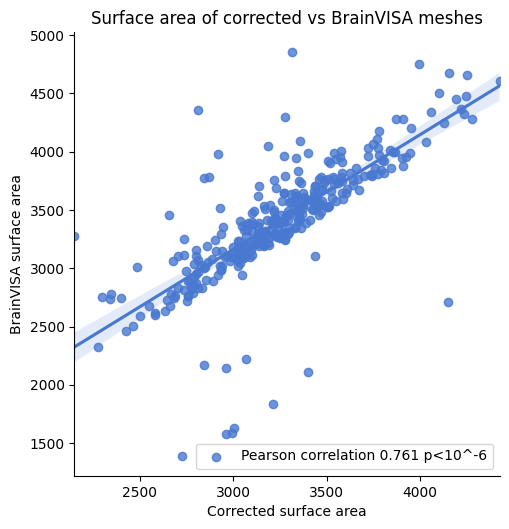

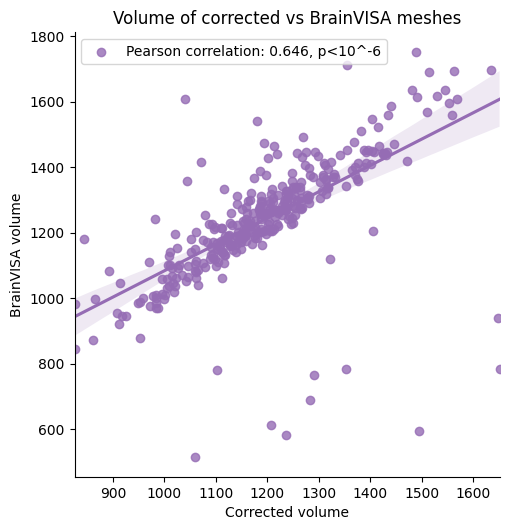

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Corrected volume,Corrected surface area,BrainVISA volume,BrainVISA surface area,Predicted volume,Predicted surface area
Corrected volume,1.000000,0.942774,0.646010,0.633434,0.644482,0.629120
Corrected surface area,0.942774,1.000000,0.763335,0.761614,0.722570,0.704094
BrainVISA volume,0.646010,0.763335,1.000000,0.994198,0.665030,0.659047
BrainVISA surface area,0.633434,0.761614,0.994198,1.000000,0.664862,0.658933
Predicted volume,0.644482,0.722570,0.665030,0.664862,1.000000,0.985536
Predicted surface area,0.629120,0.704094,0.659047,0.658933,0.985536,1.000000


In [108]:
sns.set_palette(sns.color_palette("muted"))

sns.lmplot(data=subj_meshes, x='Corrected surface area', y='BrainVISA surface area', fit_reg=True)
plt.title(f'Surface area of corrected vs BrainVISA meshes')
plt.legend(['Pearson correlation 0.761 p<10^-6'])
plt.show()

sns.set_palette(sns.color_palette("muted")[4:])
sns.lmplot(data=subj_meshes, x='Corrected volume', y='BrainVISA volume', fit_reg=True)
plt.title(f'Volume of corrected vs BrainVISA meshes')
plt.legend(['Pearson correlation: 0.646, p<10^-6'])
plt.show()
subj_meshes.corr()


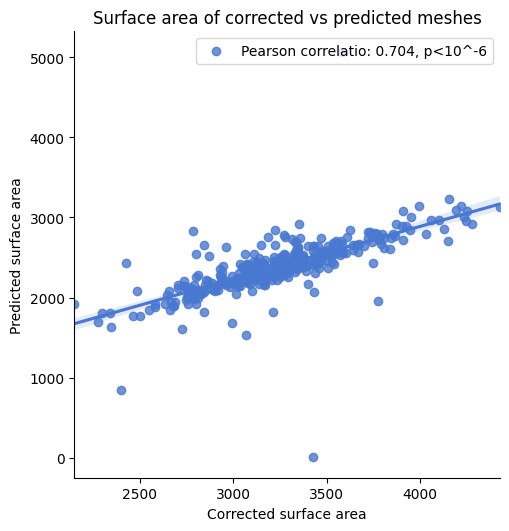

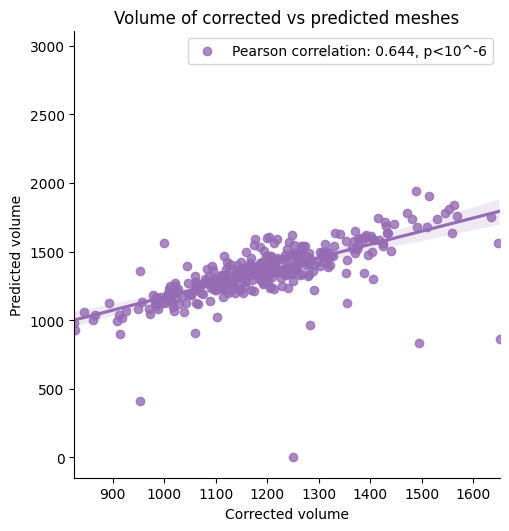

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Corrected volume,Corrected surface area,BrainVISA volume,BrainVISA surface area,Predicted volume,Predicted surface area
Corrected volume,1.000000,0.942774,0.646010,0.633434,0.644482,0.629120
Corrected surface area,0.942774,1.000000,0.763335,0.761614,0.722570,0.704094
BrainVISA volume,0.646010,0.763335,1.000000,0.994198,0.665030,0.659047
BrainVISA surface area,0.633434,0.761614,0.994198,1.000000,0.664862,0.658933
Predicted volume,0.644482,0.722570,0.665030,0.664862,1.000000,0.985536
Predicted surface area,0.629120,0.704094,0.659047,0.658933,0.985536,1.000000


In [110]:
sns.set_palette(sns.color_palette("muted"))

sns.lmplot(data=subj_meshes, x='Corrected surface area', y='Predicted surface area', fit_reg=True)
plt.title(f'Surface area of corrected vs predicted meshes')
plt.legend(['Pearson correlatio: 0.704, p<10^-6'])
plt.show()

sns.set_palette(sns.color_palette("muted")[4:])
sns.lmplot(data=subj_meshes, x='Corrected volume', y='Predicted volume', fit_reg=True)
plt.title(f'Volume of corrected vs predicted meshes')
plt.legend([f'Pearson correlation: 0.644, p<10^-6'])
plt.show()
subj_meshes.corr()


In [ ]:
The Pearson correlation coefficient between the two methods is 0.910 when considering all scans, and 0.906 for T1-weighted scans only (P < 10−9 in both cases).

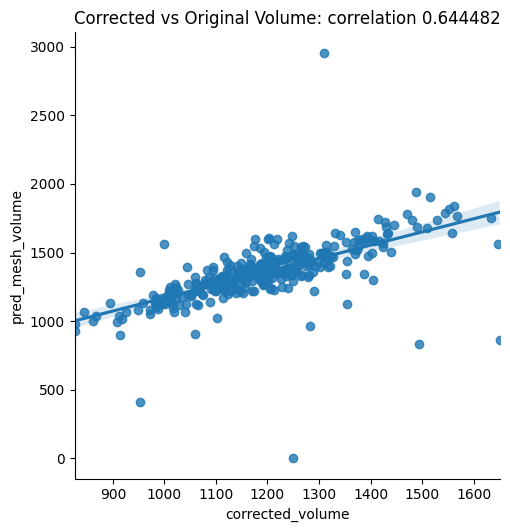

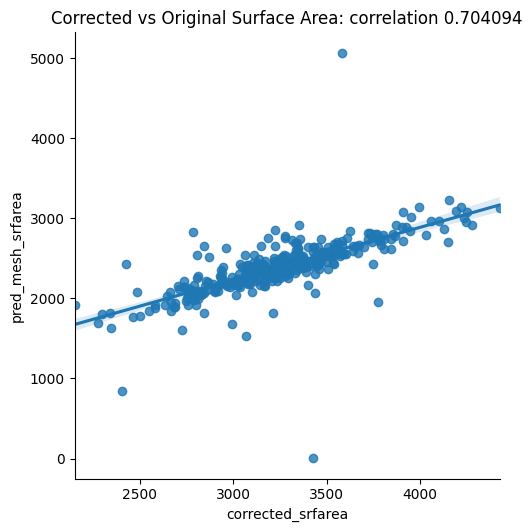

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,corrected_volume,corrected_srfarea,orig_mesh_volume,orig_mesh_srfarea,pred_mesh_volume,pred_mesh_srfarea
corrected_volume,1.000000,0.942774,0.646010,0.633434,0.644482,0.629120
corrected_srfarea,0.942774,1.000000,0.763335,0.761614,0.722570,0.704094
orig_mesh_volume,0.646010,0.763335,1.000000,0.994198,0.665030,0.659047
orig_mesh_srfarea,0.633434,0.761614,0.994198,1.000000,0.664862,0.658933
pred_mesh_volume,0.644482,0.722570,0.665030,0.664862,1.000000,0.985536
pred_mesh_srfarea,0.629120,0.704094,0.659047,0.658933,0.985536,1.000000


In [61]:

sns.lmplot(data=subj_meshes, x='corrected_volume', y='pred_mesh_volume', fit_reg=True)
plt.title(f'Corrected vs Original Volume: correlation {	0.644482}')
plt.show()
sns.lmplot(data=subj_meshes, x='corrected_srfarea', y='pred_mesh_srfarea', fit_reg=True)
plt.title(f'Corrected vs Original Surface Area: correlation {0.704094}')
plt.show()
subj_meshes.corr()


In [62]:
subj_meshes.mean()

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


corrected_volume     1193.828031
corrected_srfarea    3244.888816
orig_mesh_volume     1239.310806
orig_mesh_srfarea    3401.327927
pred_mesh_volume     1355.899133
pred_mesh_srfarea    2391.574287
dtype: float64

In [42]:
mp = '/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/meshes/Lsulcsub-via010.ply'

In [49]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [50]:
o3d_mesh = o3d.io.read_triangle_mesh(str(mp))

In [51]:
o3d_mesh.compute_vertex_normals()

TriangleMesh with 1628 points and 3252 triangles.

In [52]:
o3d.visualization.draw_geometries([o3d_mesh])

[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

In [43]:
mesh = trimesh.load(mp)

In [44]:
mesh.volume

1360.6941942676785

In [45]:
mesh.area

2435.9197465490497

In [48]:
# plot
# trimesh.Scene([mesh]).show()

In [17]:
import SimpleITK as sitk

In [30]:
sup = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/CFIN/LSulci_sub-via010_default_session_best_edit_NHT.nii.gz')
notsup = sitk.ReadImage('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/correctes_res/predicted/segmentations/Rsulcsub-via231.nii.gz')

In [31]:
sup.GetPixelIDTypeAsString()

'16-bit signed integer'

In [32]:
notsup.GetPixelIDTypeAsString() 

'16-bit signed integer'